# 시계열 모멘텀을 이용한 동적자산배분과, Time Frame Momentum을 이용한 수익률 증대 효과
# 박사과정 3기 이현열 


## 동적자산배분?: Global 10개 자산 중 모멘텀(수익률) 상위 5개 자산에 투자
## Reference: https://investresolve.com/file/pdf/ReSolve-Adaptive-Asset-Allocation-A-Primer.pdf

## [그림: 모멘텀에 따른 향후 수익률 비교 ](https://drive.google.com/open?id=1LdwvOdZ453f7luxk491nDpikK0nfO4C_)

## Time Frame Momentum?: 기존 시계열 모멘텀의 경우 12개월 수익률 하나의 지표만 사용. 반면 Time Frame Momentum의 경우 과거 3개월부터 12개월까지 모든 기간의 수익률을

## 자산의 종류

자산군  | 세부 자산 | 티커
---------- | ---------- | ----------
주식 | 미국 주식 | SPY
주식 | 유럽 주식 | IEV
주식 | 일본 주식 | EWJ
주식 | 이머징 주식 | EEM
채권 | 미 장기채 (30+) | TLT
채권 | 미 중기채 (7-10) | IEF
대체 | 미국 부동산 | IYR
대체 | 글로벌 부동산 | RWX
대체 | 금 | GLD
# 대체 | 상품 | DBC

### 비중: 최소 분산 포트폴리오

*min* $ \sigma_p $  
s.t. $ \sum w_i = 1$ , $ 0.1 ≤ w_i ≤ 0.3 $

## Import Package  & Data import from Yahoo API

In [ ]:
# import required package

import pandas as pd
import numpy as np

from pandas import Series, DataFrame
from pandas_datareader import data
from pandas.tseries.offsets import Day, MonthEnd
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import stats

from cvxopt import matrix
from cvxopt import solvers


# Download Raw Data from yahoo #

tickers = ['SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC']
start = '2007-12-30'

all_data = {}
for ticker in tickers:
    all_data[ticker] = data.DataReader(ticker, 'yahoo', start)

    
# Bind Adjusted price for all asset and calculate return

prices = pd.DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})
prices = prices.fillna(method = 'ffill')
rets = prices.pct_change(1)
rets[np.isnan(rets)] = 0

In [ ]:
rets.head()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2007-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02,-0.008754,-0.002711,-0.004515,-0.016500,0.014403,0.007125,-0.008371,-0.004389,0.029105,0.027567
2008-01-03,-0.000483,0.001754,0.003779,0.008997,-0.001377,0.002055,-0.032387,-0.003704,0.008367,0.007709
2008-01-04,-0.024506,-0.023461,-0.025602,-0.030037,0.000211,0.002619,-0.031726,-0.021951,-0.005142,-0.005814
2008-01-07,-0.000849,0.005020,-0.006183,0.007327,0.004351,0.001817,0.009338,-0.016290,-0.004229,-0.018160


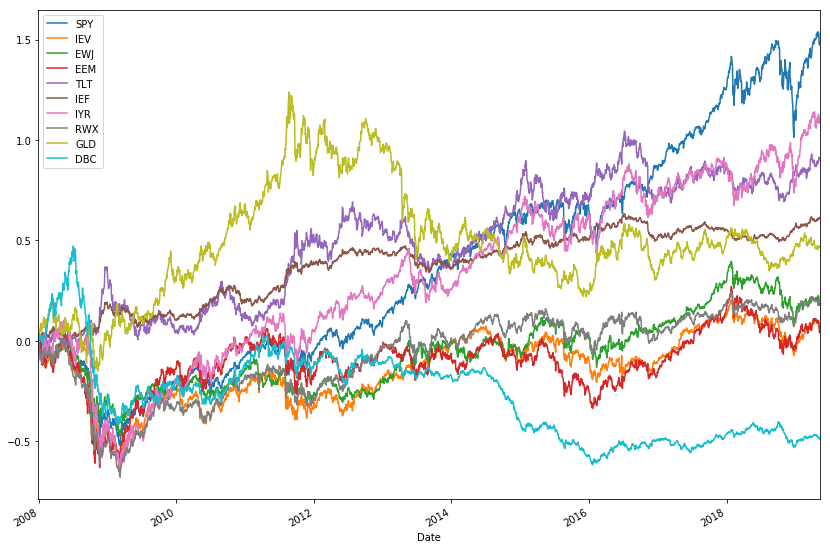

In [ ]:
# plot cumulative return

((1+rets).cumprod()-1).plot(figsize=(14,10))

## Basic Parameter & Find End of Months

### 'End of Months' function same as ep() in  PerformanceAnalytics Package in R

In [ ]:
fee = 0.0030 # transaction costs
lookback = 12 # portfolio construction period
num = 5 # number of assets to invest

# find last day of every month
s = pd.Series(np.arange(prices.shape[0]), index=prices.index)
ep = s.resample("M").max()

## Function for Minimum Volatility (using CVXOPT)

## CVXOPT Link:  https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

*min* $\frac 1 2 x^TPx + q^Tx $  
*subject to* $ Gx  ≤ h, Ax = b$

In [ ]:
solvers.options['show_progress'] = False

def MinVol(covmat, lb, ub) :
       
    P = matrix(np.array(covmat), tc = 'd') # covariance matrix
    q = matrix(np.zeros(len(covmat)), tc = 'd') # zero matrix
    
    lb_diag = np.diag(np.repeat(-1, len(covmat))) # upper boundary
    ub_diag = np.diag(np.repeat(1, len(covmat))) # lower boundary 
    
    G = matrix(np.concatenate((lb_diag, ub_diag)) , tc = 'd') # inequality constraint, left side (upper & lower boundary)
    h = matrix(np.concatenate((np.repeat(-lb, len(covmat)), np.repeat(ub, len(covmat)))), tc = 'd') # inequality constraint, right side (upper & lower boundary)
    A = matrix(np.repeat(1, len(covmat)), tc = 'd').T # equality boundary, left side (sum of weight to 1)
    b = matrix(1, tc = 'd') # equality boundary, right side (sum of weight to 1)
    
    solution = solvers.qp(P, q, G, h, A, b) # calculate x
    res = np.array(solution['x']).ravel()
    
    return(res)

# Calculate Drawdown from Portfolio Return

In [ ]:
def drawdown(R) :
    dd = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    R[np.isnan(R)] = 0
    
    for j in range(0, R.shape[1]):
        
        if (R.iloc[0, j] > 0) :
            dd.iloc[0, j] = 0
        else :
            dd.iloc[0, j] = R.iloc[0, j]
            
        for i in range(1 , len(R)):
            temp_dd = (1+dd.iloc[i-1, j]) * (1+R.iloc[i, j]) - 1
            if (temp_dd > 0) :
                dd.iloc[i, j] = 0
            else:
                dd.iloc[i, j] = temp_dd
    
    return(dd)

## Portfolio Return Backtest Function (By Return.Portfolio from R)

## Reference (Return.portfolio R code @ github)
https://github.com/cran/PerformanceAnalytics/blob/master/R/Return.portfolio.R

In [ ]:
def ReturnPortfolio(R, weights):
    
    # check for data
    if R.isnull().values.any() :
        print("NA's detected: filling NA's with zeros")
        R[np.isnan(R)] = 0

    if R.shape[1] != weights.shape[1] :
        print("Columns of Return and Weight is not same")        ## Check The Column Dimension
               
    if R.index[-1] < weights.index[0] + pd.DateOffset(days=1) :
        print("Last date in series occurs before beginning of first rebalancing period")
           
    if R.index[0] < weights.index[0] :
        R = R.loc[R.index > weights.index[0] + pd.DateOffset(days=1)]   ## Subset the Return object if the first rebalance date is after the first date 
    
    bop_value = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    eop_value = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    bop_weights = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    eop_weights = pd.DataFrame(data = np.zeros(shape = (R.shape[0], R.shape[1])), index = R.index, columns = [R.columns])
    
    bop_value_total = pd.DataFrame(data = np.zeros(shape = R.shape[0]), index = R.index)
    eop_value_total = pd.DataFrame(data = np.zeros(shape = R.shape[0]), index = R.index)
    ret = pd.DataFrame(data = np.zeros(shape = R.shape[0]), index = R.index)
                       
    end_value = 1   # The end_value is the end of period total value from the prior period
    
    k = 0
    
    for i in range(0 , len(weights) -1 ) :
        fm = weights.index[i] + pd.DateOffset(days=1)
        to = weights.index[i + 1]            
        returns = R.loc[fm : to, ]

        jj = 0
        
        for j in range(0 , len(returns) ) :
            if jj == 0 :
                bop_value.iloc[k, :] = end_value * weights.iloc[i, :]
            else :
                bop_value.iloc[k, :] = eop_value.iloc[k-1, :]
            
            bop_value_total.iloc[k] = bop_value.iloc[k, :].sum()
                        
            # Compute end of period values
            eop_value.iloc[k, :] = np.array((1 + returns.iloc[j, :])) * np.array(bop_value.iloc[k, :])
            eop_value_total.iloc[k] = eop_value.iloc[k, :].sum()
            
            # Compute portfolio returns
            ret.iloc[k] = eop_value_total.iloc[k] / end_value - 1
            end_value = float(eop_value_total.iloc[k])
            
            # Compute BOP and EOP weights
            bop_weights.iloc[k, :] = bop_value.iloc[k, :] / float(bop_value_total.iloc[k])
            eop_weights.iloc[k, :] = eop_value.iloc[k, :] / float(eop_value_total.iloc[k])
    
            jj += 1
            k += 1
    
    result = {'ret' : ret, 'bop_weights' : bop_weights, 'eop_weights' : eop_weights}
    return(result)
  
def ReturnCumulative(R) :
    R[np.isnan(R)] = 0
    
    temp = (1+R).cumprod()-1
    print("Total Return: ", round(temp.iloc[-1, :], 4)) 
    return(temp)

## Apply Return to Yearly (By apply.yearly from R)

In [ ]:
def apply_yearly(R) :
    
    s = pd.Series(np.arange(R.shape[0]), index=R.index)
    ep = s.resample("A").max()
    temp = pd.DataFrame(data = np.zeros(shape = (ep.shape[0], R.shape[1])), index = ep.index.year, columns = [R.columns])

    for i in range(0 , len(ep)) :
        if (i == 0) :
            sub_ret = R.iloc[ 0 : ep[i] + 1, :]
        else :
            sub_ret = R.iloc[ ep[i-1]+1 : ep[i] + 1, :]
        temp.iloc[i, ] = np.array((1 + sub_ret).prod() - 1)
    
    return(temp)

## Create Weight Matrix using Momentum  (12M & Time Frame Momentum)

In [ ]:
# Create Empty list for weight

wts_12M = list()
wts_TFM = list()

for i in range(lookback, len(ep)) :
    
    # Normal 12M Momentum
    cumret = prices.iloc[ep[i]] / prices.iloc[ep[i-12]] - 1
    K1 = rankdata(-cumret) <= num
    
    # Using Time Frame Momentum
    ret_temp = {}
    ret_temp = {'3M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-3]] - 1),
                '4M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-4]] - 1),
                '5M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-5]] - 1),
                '6M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-6]] - 1),
                '7M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-7]] - 1),
                '8M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-8]] - 1),
                '9M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-9]] - 1),
                '10M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-10]] - 1),
                '11M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-11]] - 1),
                '12M' : rankdata(-prices.iloc[ep[i]] / prices.iloc[ep[i-12]] - 1)}
    rank_TFM = np.sum(pd.DataFrame(ret_temp), axis = 1)
    K2 = rankdata(rank_TFM, method = 'ordinal') <= num    

    
    # Calculate Minimum Volatility Matrix (Case 1)
    subret_selected =  rets.iloc[ep[i-12] : ep[i], K1]
    cov = DataFrame.cov(subret_selected)
    
    wt = np.repeat(0.00, prices.shape[1], axis = 0)
    wt[K1] = np.array(MinVol(cov, 0.1, 0.3))
    wt = pd.DataFrame(data = wt.reshape(1,prices.shape[1]),
                      index = [prices.index[ep[i]]],
                      columns = [prices.columns])
    wts_12M.append(wt)
    
    # Calculate Minimum Volatility Matrix (Case 2)
    subret_selected =  rets.iloc[ep[i-12] : ep[i], K2]
    cov = DataFrame.cov(subret_selected)
    
    wt = np.repeat(0.00, prices.shape[1], axis = 0)
    wt[K2] = MinVol(cov, 0.1, 0.3)
    wt = pd.DataFrame(data = wt.reshape(1,prices.shape[1]),
                      index = [prices.index[ep[i]]],
                      columns = [prices.columns])
    wts_TFM.append(wt)


# Bind each weight matrix
wts_12M = pd.concat(wts_12M)    
wts_TFM = pd.concat(wts_TFM) 


## Calculate Portfolio Gross Return, Turnover, Net Return Using Pre Defined Function

## Bind Two Portfolio as 'port_final' and calculate Cumulative Return

In [ ]:
result_12M = ReturnPortfolio(rets, wts_12M)
result_TFM = ReturnPortfolio(rets, wts_TFM)

# 12M Portfolio
portfolio_ret_12M = result_12M['ret']
turnover_12M = pd.DataFrame((result_12M['eop_weights'].shift(1) - result_12M['bop_weights']).abs().sum(axis = 1))
portfolio_ret_12M_net = portfolio_ret_12M - (turnover_12M * fee)    

# TFM Portfolio
portfolio_ret_TFM = result_TFM['ret']
turnover_TFM = pd.DataFrame((result_TFM['eop_weights'].shift(1) - result_TFM['bop_weights']).abs().sum(axis = 1))
portfolio_ret_TFM_net = portfolio_ret_TFM - (turnover_TFM * fee)   

# Binding Two Portfolio
port_final = pd.concat([portfolio_ret_12M_net, portfolio_ret_TFM_net], axis = 1)
port_final.columns = ['Normal 12M Momentum', 'Time Frame Momentum']
port_cumret = ReturnCumulative(port_final)

port_dd = drawdown(port_final)
port_dd.columns = port_final.columns

## Plot Returns

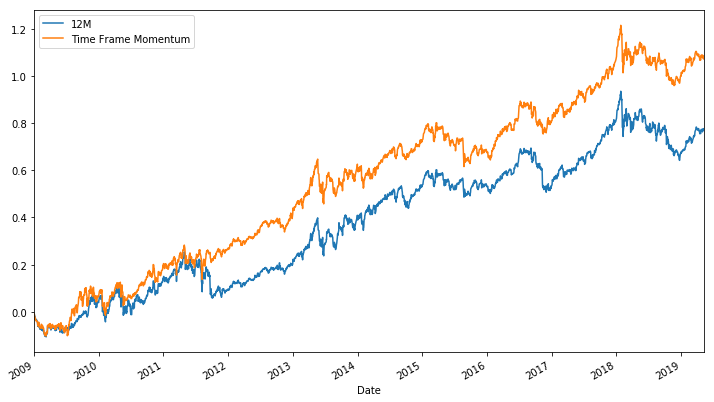

In [ ]:
port_cumret.plot(figsize=(12,7))

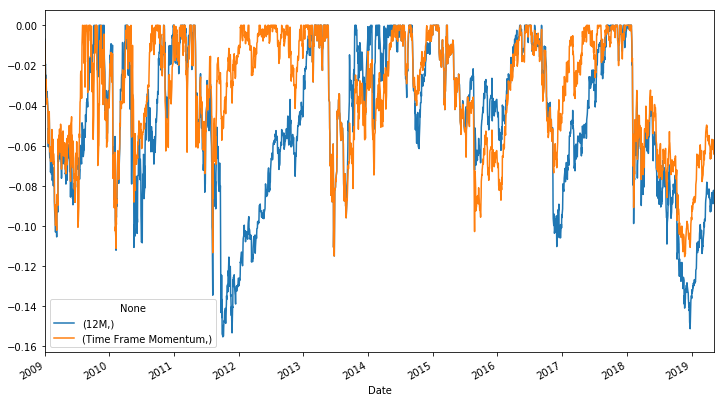

In [ ]:
port_dd.plot(figsize=(12,7))

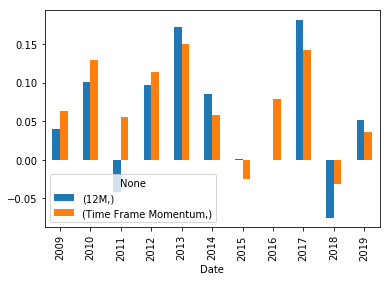

In [ ]:
apply_yearly(port_final).plot(kind = 'bar')

# Discussion and Interpretations

In [ ]:
def port_stat(R) :
    
    port_return = pd.DataFrame(R.mean() * 255).transpose()
    port_std = pd.DataFrame(np.std(R) * np.sqrt(255)).transpose()
    port_sharpe = pd.DataFrame(port_return / port_std)
    port_mdd = pd.DataFrame(drawdown(R).min()).transpose()
    port_mdd.columns = R.columns
    
    port_result= pd.concat([port_return, port_std, port_sharpe, port_mdd])
    port_result.index = ['Return', 'Std', 'Sharpe', 'MDD']
    

    return(port_result)
  

port_stat(port_final)

,12M,Time Frame Momentum
Return,0.062122,0.077340
Std,0.108746,0.108138
Sharpe,0.571254,0.715205
MDD,-0.155366,-0.115364


## 단순히 12개월 수익률 하나만 보는 것 대비 3개월에서 12개월 수익률 모든 지표를 보는 것이 더 높은 수익률과 비슷한 변동성을 보이며, 따라서 샤프지수가 상승하는 모습을 보임

## 또한 MDD가 기존 -15.5%에서 -11.5%로 감소하는 효과도 보임